In [40]:
%pylab inline
import pandas as p
from scipy.stats.mstats import zscore
from scipy import interpolate
from sklearn.model_selection import cross_val_score
from sklearn import svm
from sklearn.decomposition import PCA

from dtw import dtw

#set plot attributes
fig_width = 5  # width in inches
fig_height = 3  # height in inches
fig_size =  [fig_width,fig_height]

fig_width_pt = 300                      # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/96                  # Convert pt to inch
golden_mean = (sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height = fig_width*golden_mean      # height in inches
#fig_height = fig_width*0.35            # height in inches
fig_size =  [fig_width,fig_height]

params = {'backend': 'Agg',
          'axes.labelsize': 6.5,
          'axes.titlesize': 6.5,
          'lines.linewidth' : 0.5,
          'font.size': 5.5,
          'lines.markersize': 2.,
          'lines.markeredgewidth'  : 0.1,
          'xtick.labelsize': 5.5,
          'ytick.labelsize': 5.5,
          'xtick.direction': 'in',
          'ytick.direction': 'in',
          'figure.figsize': fig_size,
          'savefig.dpi' : 600,
          'font.family': 'sans-serif',
          'axes.linewidth' : 0.5,
          'xtick.major.size' : 1.5,
          'ytick.major.size' : 1.5,
          'font.size' : 5,
          'figure.autolayout' : False,
          'legend.fontsize': 4,
          #'legend.linewidth': 1,
          'legend.numpoints': 1,
          'legend.fancybox': True}

rcParams.update(params)

def simpleax(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    
def noax(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.get_yaxis().tick_left()
    ax.get_xaxis().set_ticklabels([])
    ax.get_xaxis().set_ticks([])
    
def accelerationplot(walk1):
    subplot(311)
    plot(walk1[:,0], zscore(walk1[:,1]))
    noax(gca())
    #xlim(x1, x2)
    ylim(-4, 4)
    #ylabel('x')
    gca().set_yticks([-3, 0, 3])
    
    subplot(312)
    plot(walk1[:,0], zscore(walk1[:,2]))
    #xlim(x1, x2)
    ylim(-4, 4)
    noax(gca())
    #ylabel('y')
    gca().set_yticks([-3, 0, 3])
    
    subplot(313)
    plot(walk1[:,0], zscore(walk1[:,3]))
    #xlim(x1, x2)
    ylim(-4, 4)
    simpleax(gca())
    #ylabel('z')
    gca().set_yticks([-3, 0, 3])
    
    xlabel('Time (s)')
    figtext(0, 0.8, 'Acceleration (normalized)', rotation='vertical')
    
def idxsfortime(walk, start_t=10, end_t=20):
    startid = where(walk[:,0]>start_t)[0][0]
    endid = where(walk[:,0]>end_t)[0][0]
    return range(startid, endid)

def interp_norm(walk):
    new_walk = np.ndarray(walk.shape)
    new_walk[:,0] = np.linspace(walk[0,0], walk[-1,0], len(walk[:,0]))
    f = interpolate.interp1d(walk[:,0], walk[:,1], kind='slinear')
    new_walk[:,1] = zscore(f(walk[:,0]))
    f = interpolate.interp1d(walk[:,0], walk[:,2], kind='slinear')
    new_walk[:,2] = zscore(f(walk[:,0]))
    f = interpolate.interp1d(walk[:,0], walk[:,3], kind='slinear')
    new_walk[:,3] = zscore(f(walk[:,0]))
    return new_walk

def dynamictimewarp(x, y):
    dist = np.zeros((len(x), len(y)))
    for i in xrange(dist.shape[0]):
        for j in xrange(dist.shape[1]):
            #dist[i, j] = sum((x[i]-y[j])**2)
            dist[i, j] = sum((x[i,:]-y[j,:])**2)
            #dist[i,j] = np.dot(x[i], y[j])
    
    cost = np.zeros((len(x), len(y)))
    cost[-1,:] = float('inf')
    cost[:,-1] = float('inf')
    cost[-1,-1] = 0
    path = [(0, 0)]
    for i in xrange(cost.shape[0]):
        for j in xrange(cost.shape[1]):
            cost[i, j] = dist[i, j]+min((cost[i-1,j], cost[i-1,j-1], cost[i,j-1]))
    
    return cost[-1, -1], cost, trackpath(cost)

def trackpath(cost):
    i, j = array(cost.shape) - 1
    p, q = [i], [j]
    while (i > 0 and j > 0):
        tb = argmin((cost[i-1, j-1], cost[i-1, j], cost[i, j-1]))
        cases = {0: (i-1, j-1),
                1: (i-1, j),
                2: (i, j-1)}

        i, j = cases[tb]
        p.insert(0, i)
        q.insert(0, j)

    p.insert(0, 0)
    q.insert(0, 0)
    return (array(p), array(q))

def scoreSVC(features, labels):
    '''
    Prints 10-fold cross validation accuracy score with svm classifier
    corrvect: (n_sample, n_features)
    labels: (n_sample)
    '''
    clf = svm.SVC(kernel='linear', C=5)
    folds = 10
    scores = cross_val_score(clf, corrvect, labels, cv=folds)
    print labels.shape[0], ' samples ', len(unique(labels)), ' classes '
    print '(',folds,' folds) cross-validation '
    print 'each fold has: ', labels.shape[0]/folds, 'samples for testing ', 9*labels.shape[0]/folds, ' for training'
    print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
    print 'Scores each fold:'
    print scores
    
def datafeature(data):
    # Example data x axis
    subplot(311)
    plot(data[:,1])
    # Example data y axis
    subplot(312)
    plot(data[:,2])
    # Example data z axis
    subplot(313)
    plot(data[:,3])

    print 'corr(a_x,a_y) / corr(a_x,a_z) / corr(a_y,a_z)'
    c = np.corrcoef(data[0:150,:].T)
    print [c[0,1], c[0,2], c[1,2]]
    c = np.corrcoef(data[150:300,:].T)
    print [c[0,1], c[0,2], c[1,2]]
    c = np.corrcoef(data[300:450,:].T)
    print [c[0,1], c[0,2], c[1,2]]
    c = np.corrcoef(data[450:600,:].T)
    print [c[0,1], c[0,2], c[1,2]]
    
def wholesetfeature(data):
    # Example data x axis
    subplot(311)
    plot(data[:,0])
    # Example data y axis
    subplot(312)
    plot(data[:,1])
    # Example data z axis
    subplot(313)
    plot(data[:,2])

    print 'corr(a_x,a_y) / corr(a_x,a_z) / corr(a_y,a_z)'
    c = np.corrcoef(data.T)
    print [c[0,1], c[0,2], c[1,2]]

Populating the interactive namespace from numpy and matplotlib


In [41]:
# Handpick the walking data
# Time-windows in the data during stable walking.
walks = {}
windows = [30, 80, 10, 50, 5, 40, 80, 60, 50, 20, 40, 40, 40, 60, 40, 25, 150, 250, 5, 100, 25, 50]
for i in xrange(22):
    data = p.read_csv('data/'+str(i+1)+'.csv')
    walk = data.values
    walks[i+1] = walk[idxsfortime(walk, windows[i], windows[i]+20),:]

In [42]:
# Interpolate and normalize
# z-score within the given window. interpolation (is it needed?)

data = {}
for key in walks.keys():
    data[key] = interp_norm(walks[key])
    #print key, len(data[key])

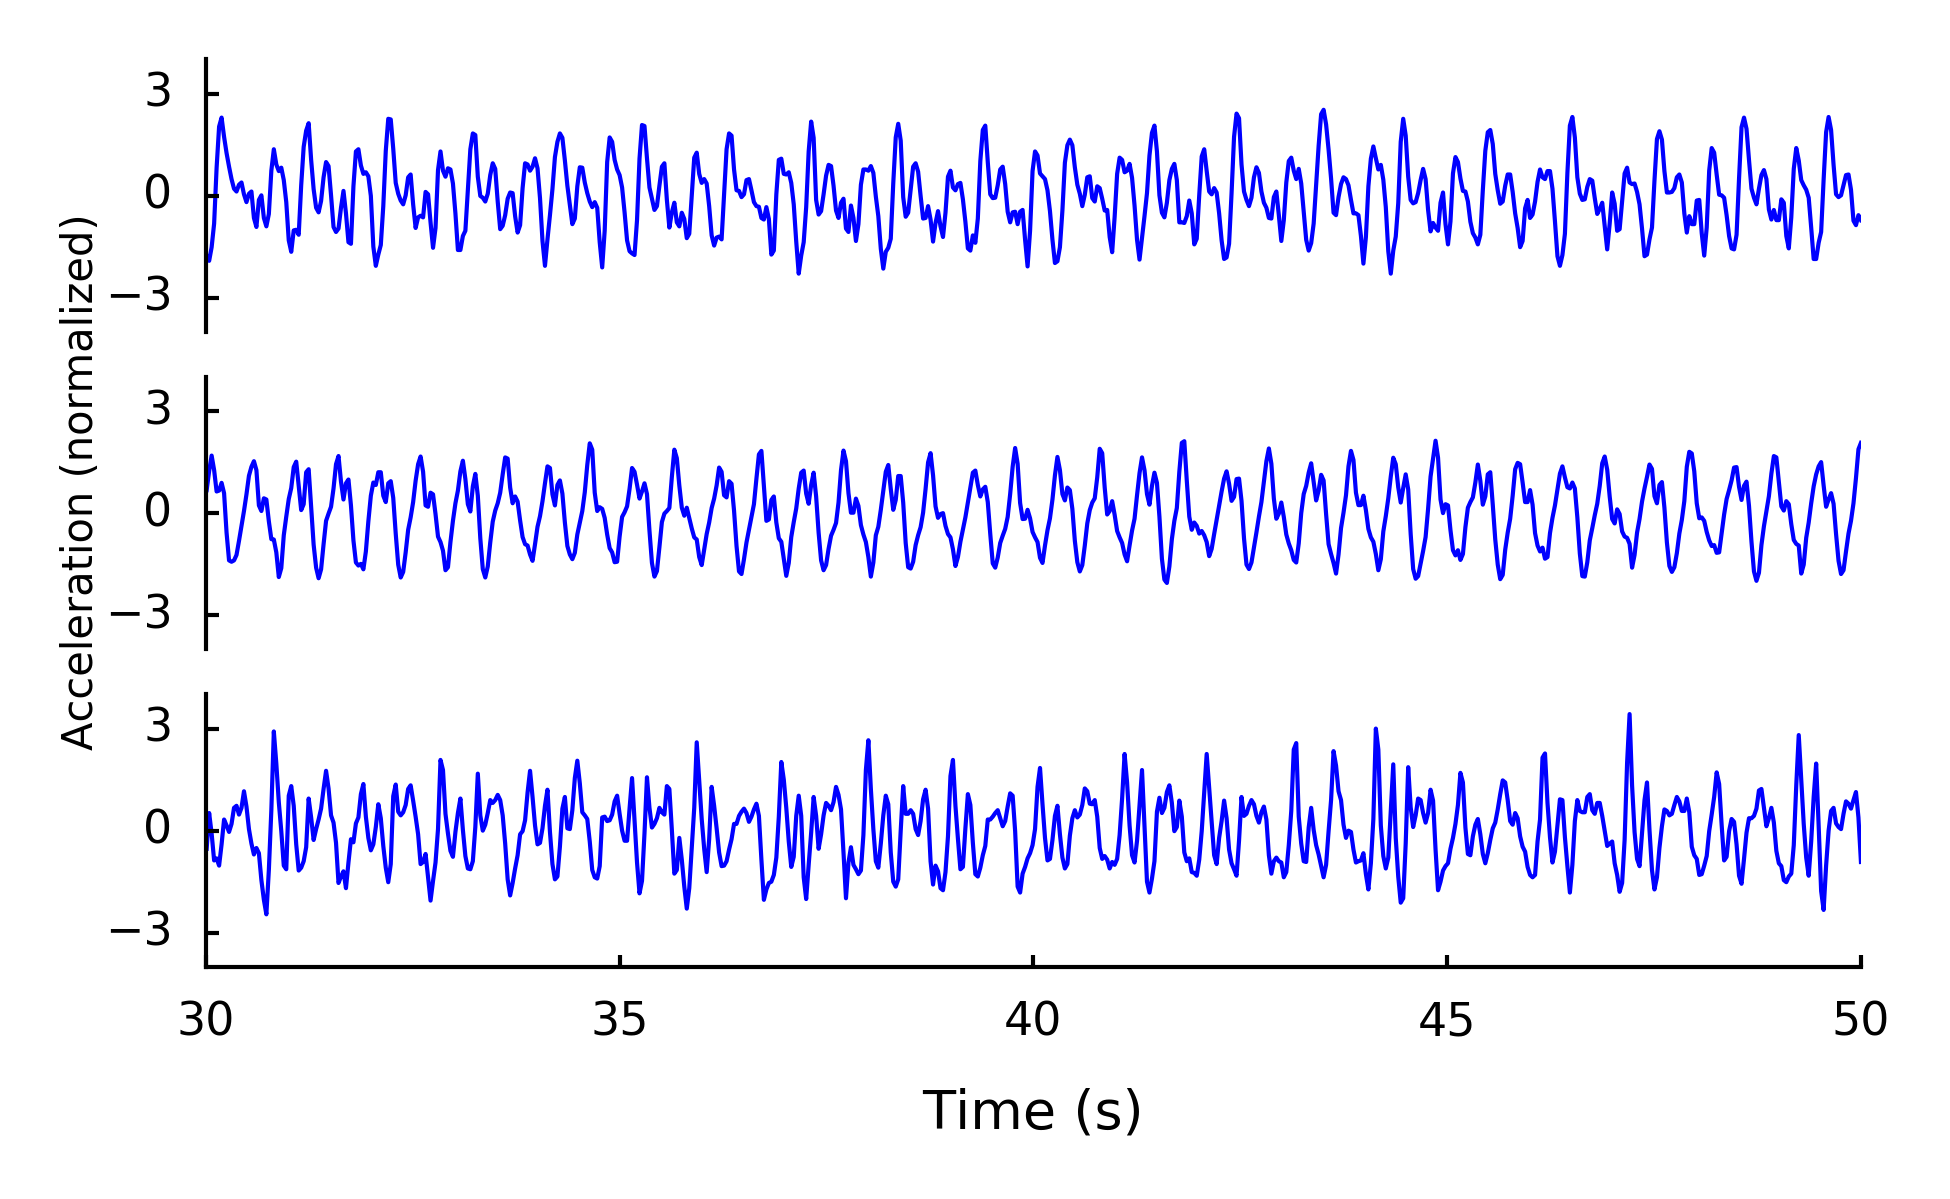

In [43]:
accelerationplot(data[1])
tight_layout()
savefig('slidingwindow.pdf')

corr(a_x,a_y) / corr(a_x,a_z) / corr(a_y,a_z)
[0.010448892942973558, -0.065815813787200791, -0.32063999833729639]
[-0.067931756706170493, -0.051943182866183595, -0.32887347763656943]
[0.076891558943685503, 0.089280184886871852, -0.25390470861435926]
[-0.046601110332152508, 0.066844460085978344, -0.35100370603658726]


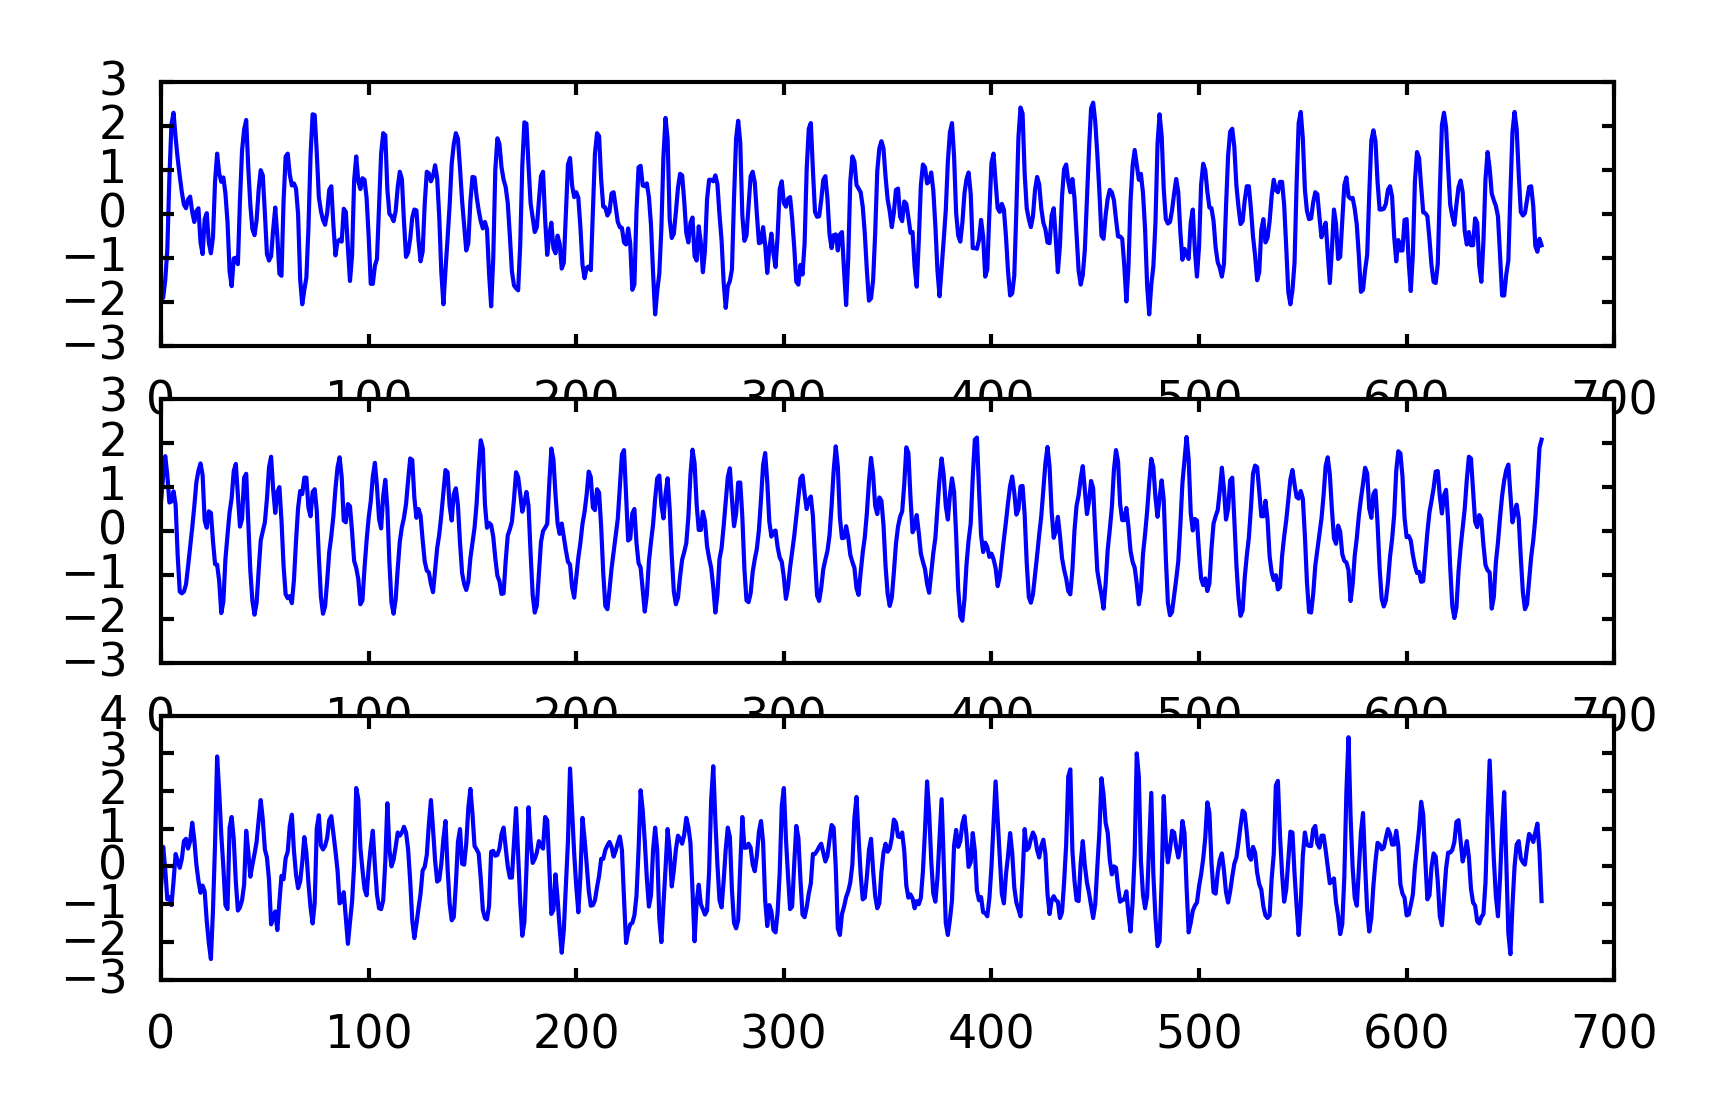

In [44]:
datafeature(data[1])

corr(a_x,a_y) / corr(a_x,a_z) / corr(a_y,a_z)
[-0.063565018900445372, -0.0035778706206364749, -0.25982433538385474]
[0.35417023470205777, 0.0069691571670275456, -0.28786646859344572]
[0.020338456472304887, -0.075341396805641878, -0.17659786192685092]
[0.059548161774391838, -0.069427951508690605, -0.33084157668301106]


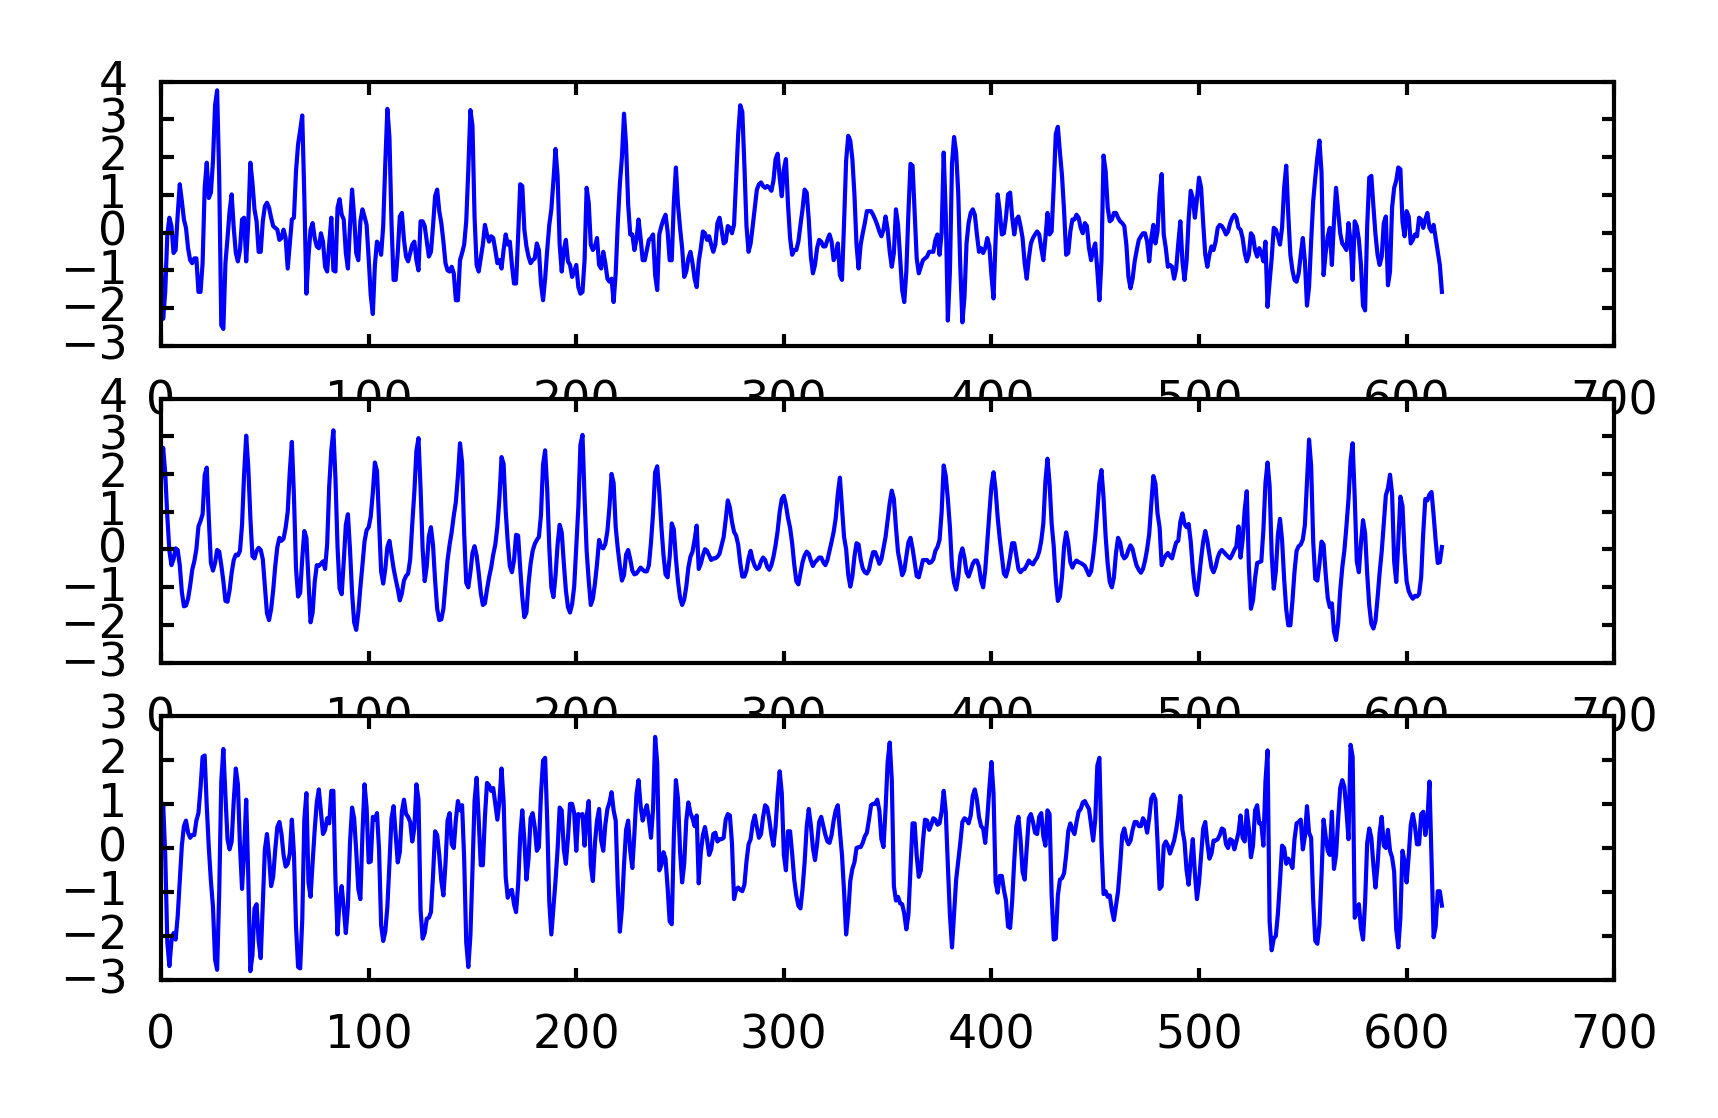

In [45]:
datafeature(data[21])

In [46]:
# Generate_sets
# with a sliding_window to generate samples

# Here we have some hyperparameters, paying attention on:
# klen: the size of time window
# stride: time shift on the series
klen = 150
stride = 10

# perperson: the number of samples per class (depends on how much we can harvest from the data)
# labels: the class id a sample belong to (it is ordered in the beginning but crossvalidation will scramble)
perperson = 45 #up to perperson*stride+klen<600
wholeset = np.ndarray((perperson*22, klen, 3))
labels = np.zeros(perperson*22)

for j, key in enumerate(data.keys()):
    for i in xrange(perperson):
        wholeset[perperson*j+i] = data[key][i*stride:i*stride+klen,1:4]
        labels[perperson*j+i] = key
            
print wholeset.shape

corrvect = np.ndarray((len(wholeset), 3))
for i in xrange(len(wholeset)):
    c = np.corrcoef(wholeset[i].T)
    corrvect[i] = [c[0,1], c[0,2], c[1,2]]
    
print corrvect.shape

(990, 150, 3)
(990, 3)


In [47]:
#for i in data.keys():
#    print data[i].shape[0]

corr(a_x,a_y) / corr(a_x,a_z) / corr(a_y,a_z)
[-0.30699074435870033, 0.16478027345781426, -0.32315047964135479]


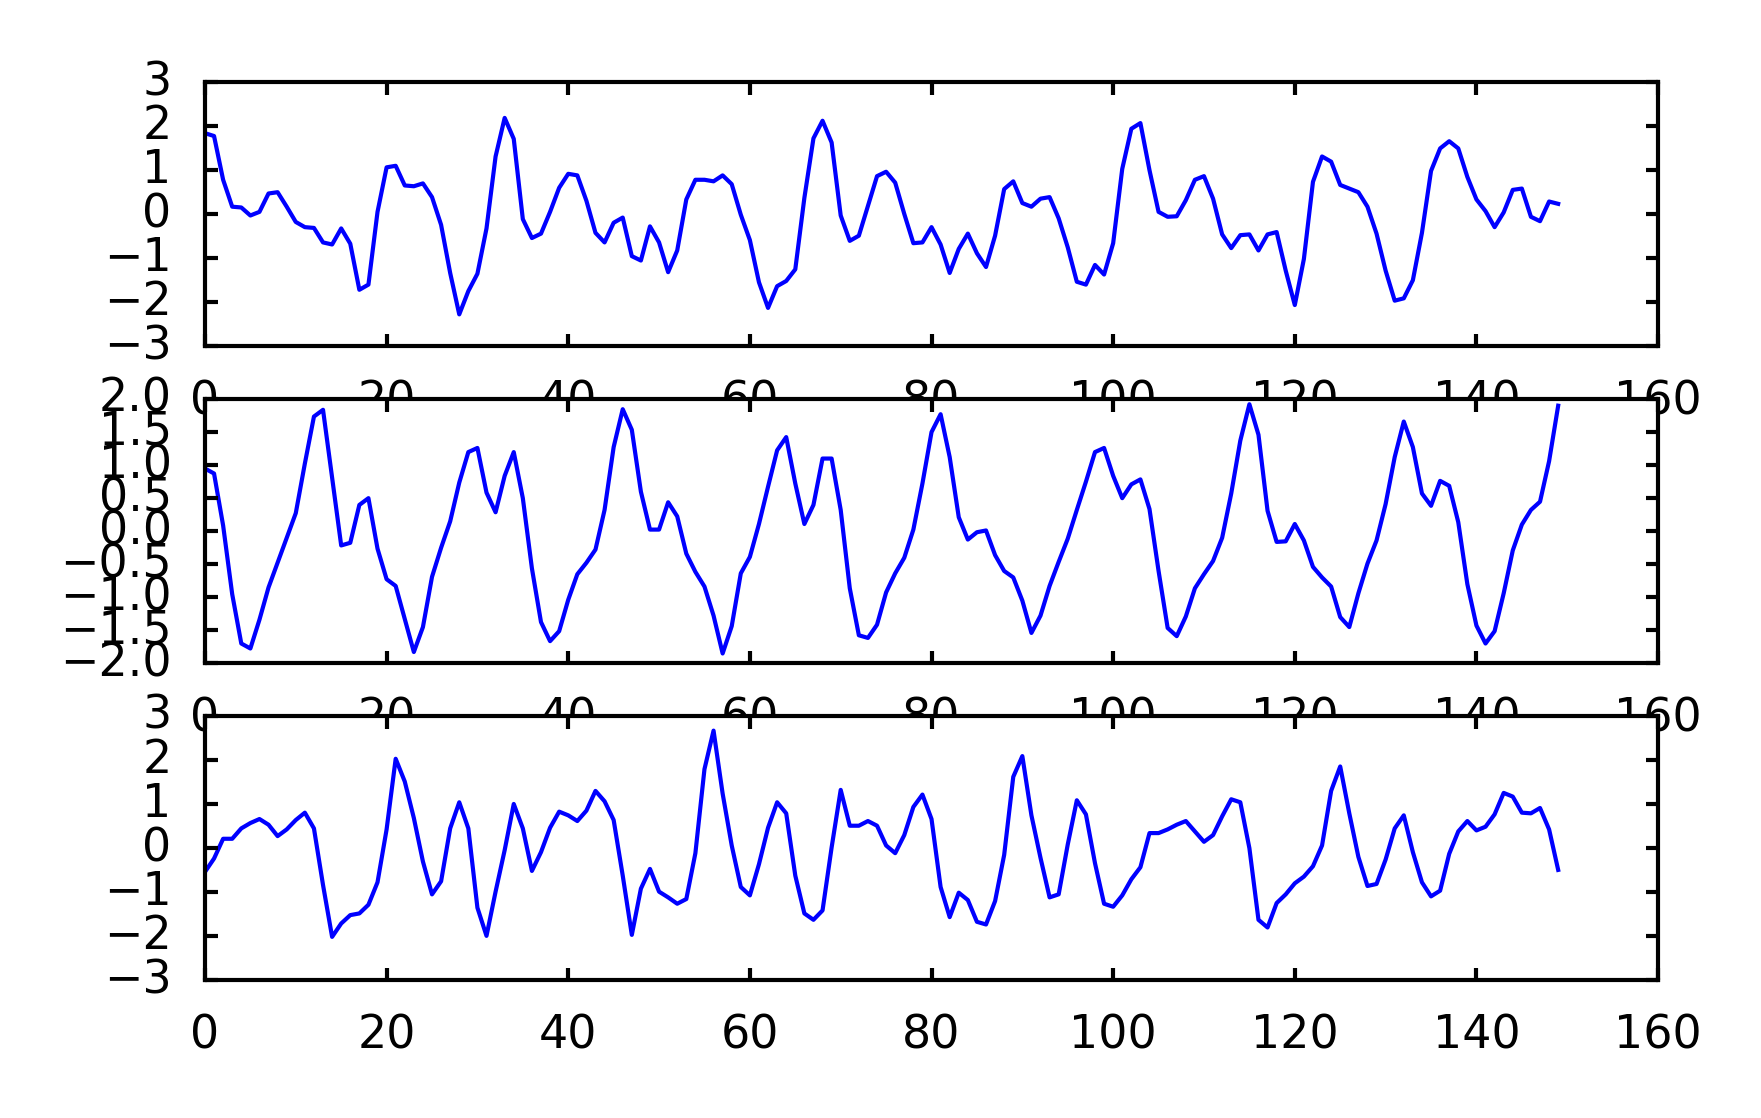

In [48]:
wholesetfeature(wholeset[21])

In [49]:
#wholesetfeature(wholeset[20])
c = np.corrcoef(wholeset[20].T)
print [c[0,1], c[0,2], c[1,2]]

c = np.corrcoef(wholeset[20,0:50,:].T)
print [c[0,1], c[0,2], c[1,2]]
c = np.corrcoef(wholeset[20,50:100,:].T)
print [c[0,1], c[0,2], c[1,2]]
c = np.corrcoef(wholeset[20,100:150,:].T)
print [c[0,1], c[0,2], c[1,2]]


[-0.34202336976144693, 0.13020698626666546, -0.31205586192192641]
[-0.26816931553695894, 0.15935666959825007, -0.28593053960555398]
[-0.40202131134999119, 0.17980833490083578, -0.33502806887147341]
[-0.36629941677462341, 0.052162670876469849, -0.31979008428059913]


In [50]:
# Train-test an SVM classifier
# Generate 10-fold cross-validation scores

from sklearn.model_selection import cross_val_score
clf = svm.SVC(kernel='linear', C=5)
folds = 10
scores = cross_val_score(clf, corrvect, labels, cv=folds)
print labels.shape[0], ' samples ', len(unique(labels)), ' classes '
print '(',folds,' folds) cross-validation '
print 'each fold has: ', labels.shape[0]/folds, 'samples for testing ', 9*labels.shape[0]/folds, ' for training'
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print 'Scores each fold:'
print scores

990  samples  22  classes 
( 10  folds) cross-validation 
each fold has:  99 samples for testing  891  for training
Accuracy: 0.84 (+/- 0.11)
Scores each fold:
[ 0.80909091  0.83636364  0.91818182  0.86363636  0.86363636  0.82954545
  0.875       0.875       0.78409091  0.71590909]


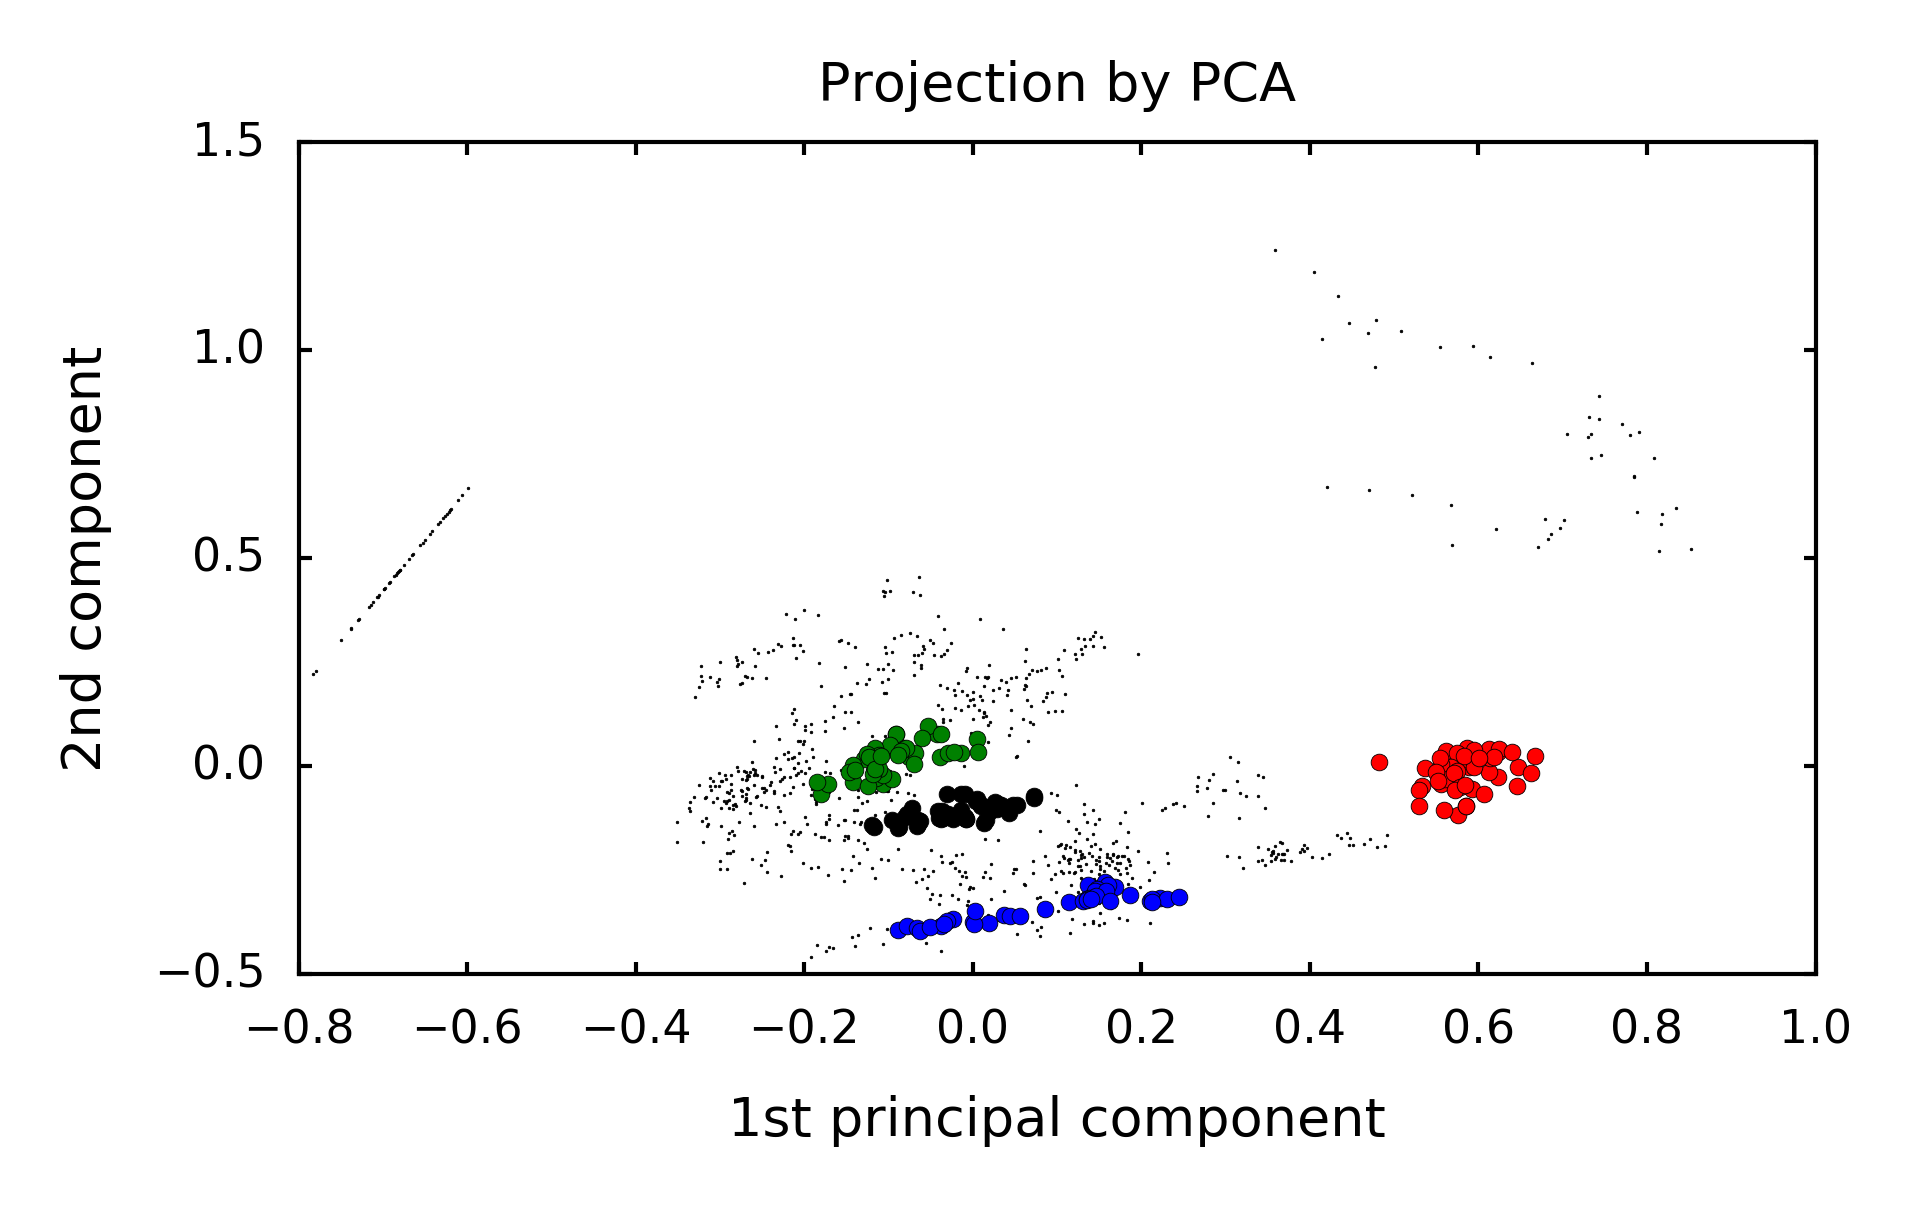

In [51]:
# PCA with 3 components
# samples from 4 classes are highlighted (by color)

pca = PCA(n_components=3)
X_pca = pca.fit_transform(corrvect)

# plot the data projected on first two principal components
plt.plot(X_pca[:, 0], X_pca[:, 1], "ko", markersize=0.3)
plt.plot(X_pca[labels==1, 0], X_pca[labels==1, 1], "ro")
plt.plot(X_pca[labels==10, 0], X_pca[labels==10, 1], "bo")
plt.plot(X_pca[labels==20, 0], X_pca[labels==20, 1], "go")
plt.plot(X_pca[labels==15, 0], X_pca[labels==15, 1], "ko")
plt.title("Projection by PCA")
plt.xlabel("1st principal component")
plt.ylabel("2nd component")
tight_layout()
savefig('pca_12_overlapping.pdf')

In [29]:
# How much variance each principal component benefits
pca.explained_variance_ratio_

array([ 0.41565112,  0.37199391,  0.21235497])

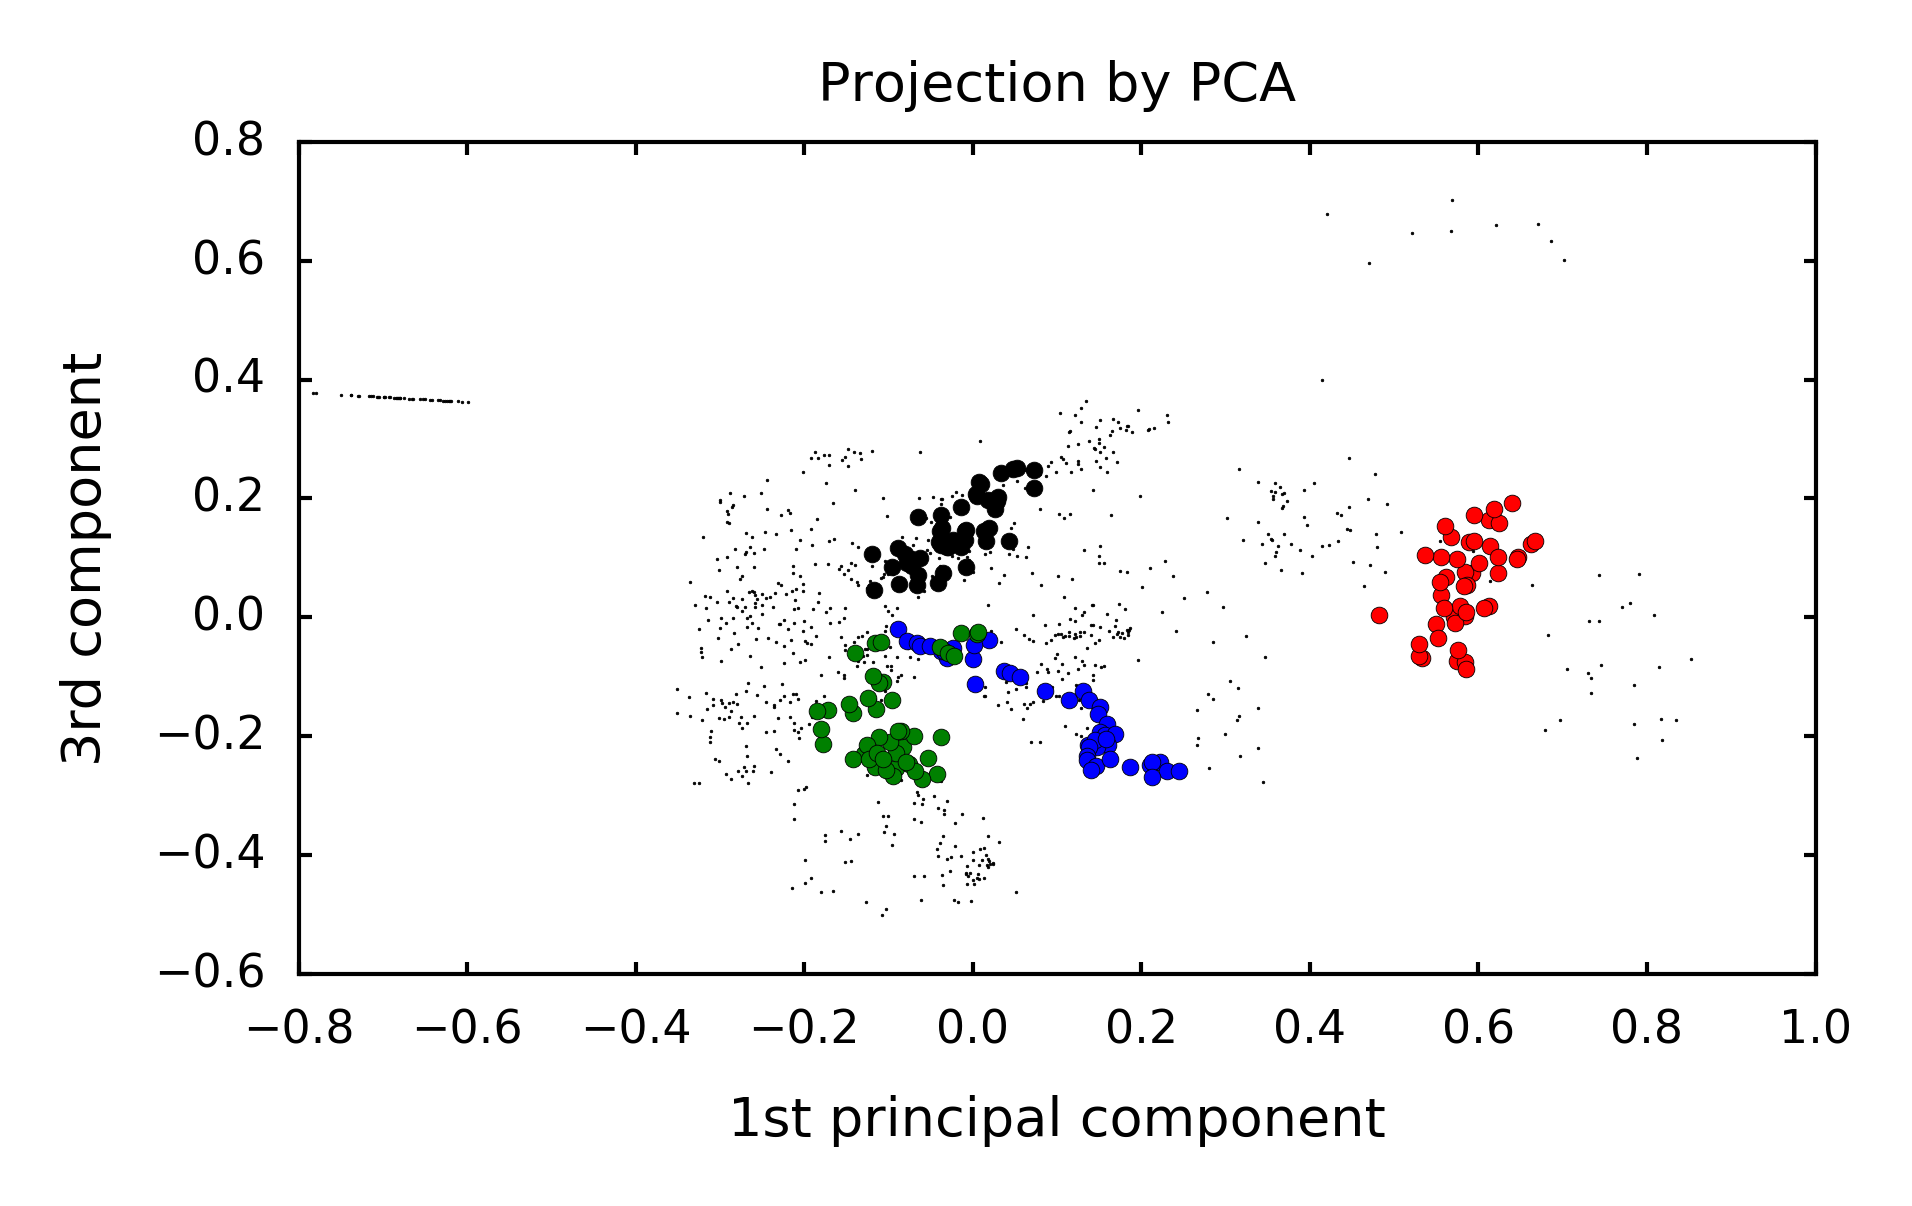

In [30]:
# plot the projection on 1st and 3rd principal components
X_pca = pca.fit_transform(corrvect)
plt.plot(X_pca[:, 0], X_pca[:, 2], "ko", markersize=0.3)
plt.plot(X_pca[labels==1, 0], X_pca[labels==1, 2], "ro")
plt.plot(X_pca[labels==10, 0], X_pca[labels==10, 2], "bo")
plt.plot(X_pca[labels==20, 0], X_pca[labels==20, 2], "go")
plt.plot(X_pca[labels==15, 0], X_pca[labels==15, 2], "ko")
plt.title("Projection by PCA")
plt.xlabel("1st principal component")
plt.ylabel("3rd component")
tight_layout()
savefig('pca_13_overlapping.pdf')

In [31]:
## From here onwards: dynamic time warping (depreceated)

 223.912028143


(-0.5, 149.5)

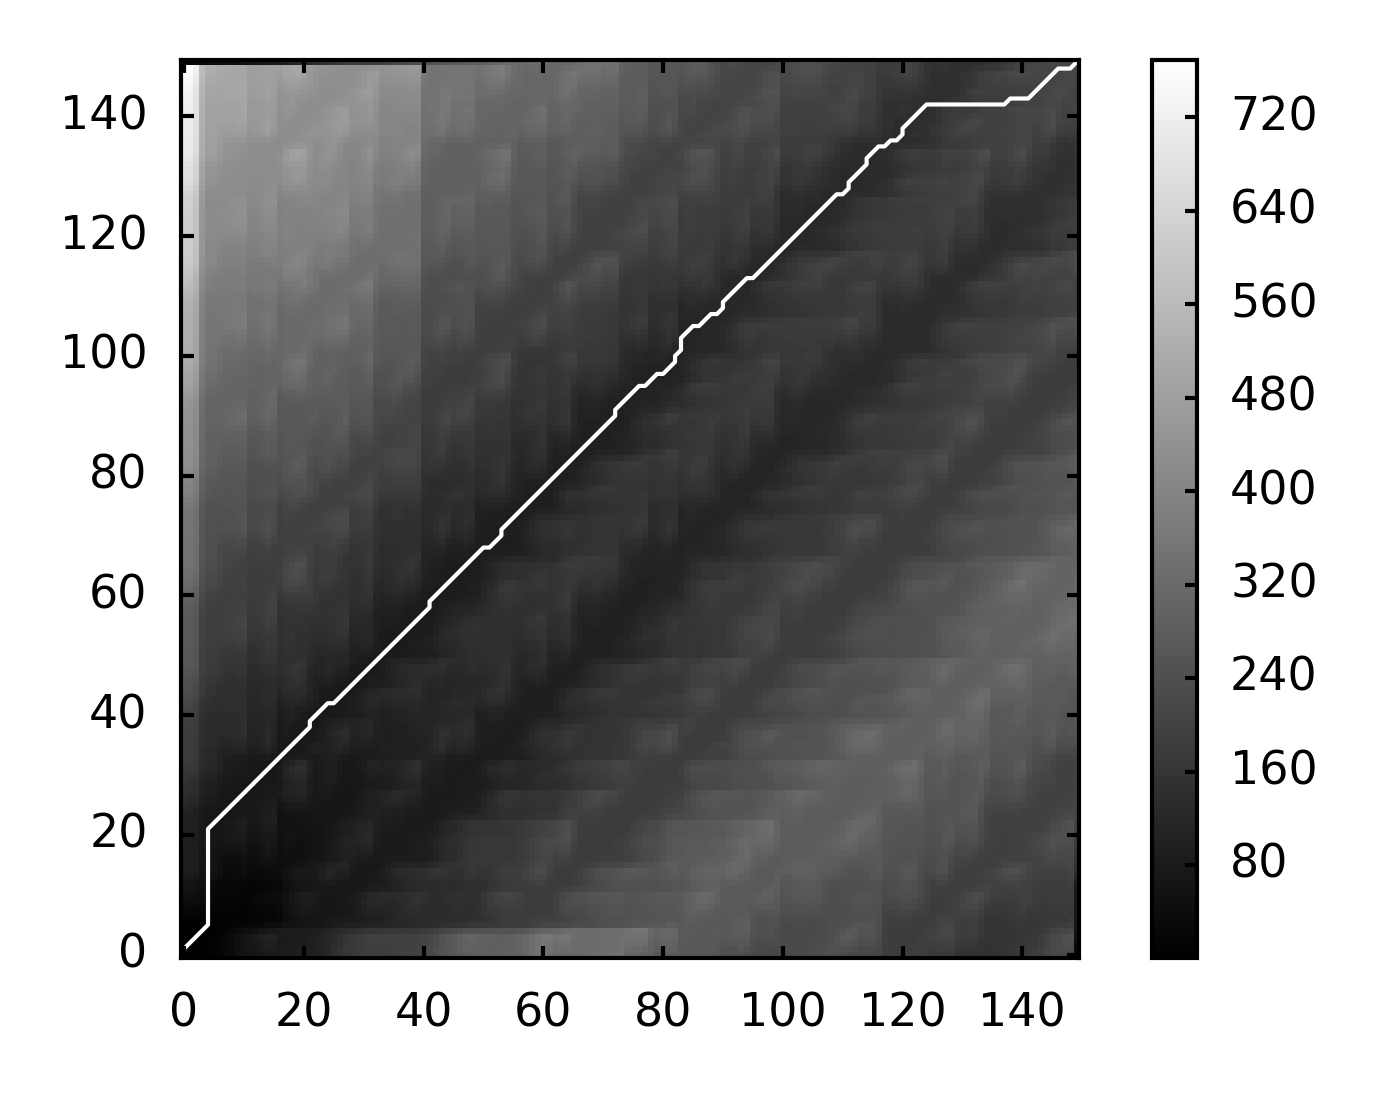

In [35]:
dist, cost, path = dynamictimewarp(wholeset[1], wholeset[6])
print dist
imshow(cost.T, interpolation='nearest', cmap=cm.gray)
colorbar()
plot(path[0], path[1], 'w')
xlim((-0.5, cost.shape[0]-0.5))
ylim((-0.5, cost.shape[1]-0.5))

(-0.5, 149.5)

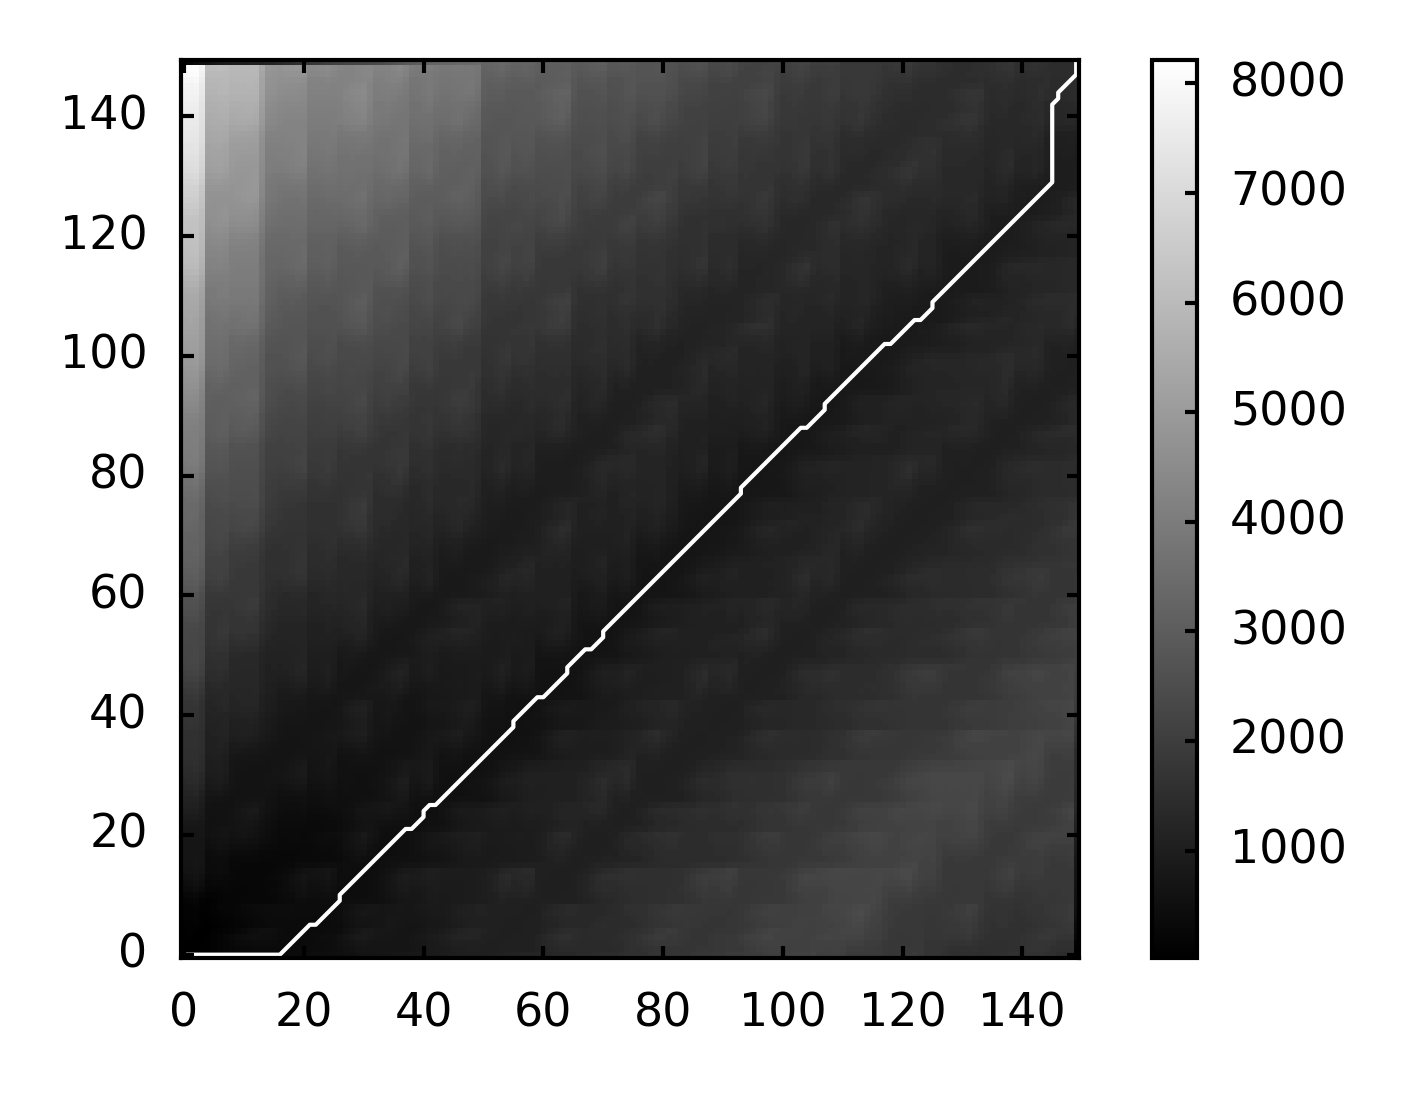

In [38]:
dist, cost, path = dynamictimewarp(walks[1][:150,:], walks[1][50:200,:])
imshow(cost.T, interpolation='nearest', cmap=cm.gray)
colorbar()
plot(path[0], path[1], 'w')
xlim((-0.5, cost.shape[0]-0.5))
ylim((-0.5, cost.shape[1]-0.5))